In [3]:
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf
from scipy import stats

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)  

# Some styling
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

import plotly.io as pio
pio.renderers.default = 'colab'
pio.templates.default = 'ggplot2'
%matplotlib inline

# Disable warnings 
import warnings
warnings.filterwarnings('ignore')

In [4]:
raw_data_link = 'https://raw.githubusercontent.com/elvanselvano/purwadhika-final-project/main/dataset/dev2.csv'
df = pd.read_csv(raw_data_link) #using dev set

In [5]:
df.head()

,index,BATHRM,HF_BATHRM,HEAT,AC,NUM_UNITS,ROOMS,BEDRM,AYB,YR_RMDL,EYB,STORIES,SALEDATE,PRICE,QUALIFIED,SALE_NUM,GBA,BLDG_NUM,STYLE,STRUCT,GRADE,CNDTN,EXTWALL,ROOF,INTWALL,KITCHENS,FIREPLACES,USECODE,LANDAREA,GIS_LAST_MOD_DTTM,SOURCE,CMPLX_NUM,LIVING_GBA,FULLADDRESS,CITY,STATE,ZIPCODE,NATIONALGRID,LATITUDE,LONGITUDE,ASSESSMENT_NBHD,ASSESSMENT_SUBNBHD,CENSUS_TRACT,CENSUS_BLOCK,WARD,SQUARE,X,Y,QUADRANT,SALEYEAR
0,2,3,1,Hot Water Rad,Y,2.0,9,5,1910.0,2009.0,1984,3.0,2016-06-21,2100000.0,Q,3,2522.0,1,3 Story,Row Inside,Very Good,Very Good,Common Brick,Built Up,Hardwood,2.0,4,24,1680,2018-07-22 18:01:43,Residential,NaN,NaN,1744 SWANN STREET NW,WASHINGTON,DC,20009.0,18S UJ 23074 09289,38.914684,-77.040678,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,152,-77.040429,38.914881,NW,2016.0
1,18,3,1,Hot Water Rad,Y,2.0,10,4,1908.0,2006.0,1967,2.0,2016-08-18,NaN,U,6,1542.0,1,2 Story,Row Inside,Above Average,Good,Common Brick,Metal- Sms,Hardwood,2.0,1,24,1424,2018-07-22 18:01:43,Residential,NaN,NaN,1731 SWANN STREET NW,WASHINGTON,DC,20009.0,18S UJ 23132 09324,38.915016,-77.040020,Old City 2,040 D Old City 2,4201.0,004201 2005,Ward 2,152,-77.040429,38.914881,NW,2016.0
2,20,3,1,Hot Water Rad,Y,1.0,14,5,1880.0,2009.0,1987,3.0,2016-01-12,33232.0,U,3,3465.0,1,3 Story,Semi-Detached,Very Good,Very Good,Common Brick,Built Up,Hardwood,1.0,3,13,2090,2018-07-22 18:01:43,Residential,NaN,NaN,1441 Q STREET NW,WASHINGTON,DC,20009.0,18S UJ 23665 08908,38.911370,-77.033774,Old City 2,040 E Old City 2,5201.0,005201 4003,Ward 2,208,-77.033366,38.911716,NW,2016.0
3,21,3,0,Forced Air,Y,2.0,12,3,1880.0,2009.0,1969,3.0,2014-04-30,NaN,U,4,2912.0,1,3 Story,Semi-Detached,Good Quality,Good,Common Brick,Built Up,Hardwood,2.0,1,24,2090,2018-07-22 18:01:43,Residential,NaN,NaN,1443 Q STREET NW,WASHINGTON,DC,20009.0,18S UJ 23659 08907,38.911368,-77.033838,Old City 2,040 E Old City 2,5201.0,005201 4003,Ward 2,208,-77.033366,38.911716,NW,2014.0
4,28,3,0,Warm Cool,Y,2.0,10,4,1900.0,1960.0,1960,4.0,2015-02-06,NaN,U,3,3610.0,1,4 Story,Row Inside,Good Quality,Average,Common Brick,Built Up,Hardwood/Carp,2.0,5,24,1853,2018-07-22 18:01:43,Residential,NaN,NaN,1454 CORCORAN STREET NW,WASHINGTON,DC,20009.0,18S UJ 23635 08942,38.911677,-77.034119,Old City 2,040 E Old City 2,5201.0,005201 4003,Ward 2,208,-77.033366,38.911716,NW,2015.0


### 1. CASTING

In [6]:
#casting data types
def casting(df):
  df['NUM_UNITS'] = df['NUM_UNITS'].astype(pd.Int64Dtype())
  df['AYB'] = df['AYB'].astype(pd.Int64Dtype())
  df['LANDAREA'] = df['LANDAREA'].astype(float)
  df['KITCHENS'] = df['KITCHENS'].astype(pd.Int64Dtype())
  df['USECODE'] = df['USECODE'].astype(pd.Int64Dtype()).astype('category')
  df['ZIPCODE'] = df['ZIPCODE'].astype(pd.Int64Dtype()).astype('category')
  df['CMPLX_NUM'] = df['CMPLX_NUM'].astype(pd.Int64Dtype())
  df['CENSUS_TRACT'] = df['CMPLX_NUM'].astype(pd.Int64Dtype())
  df['SALEDATE'] = pd.to_datetime(df['SALEDATE'])
  return df

In [7]:
df1 = casting(df)

In [8]:
def saleyear(df):
  df['SALEYEAR'] = df['SALEDATE'].dt.year
  return df

In [9]:
df2 = saleyear(df1)

### 2. QUALIFIED FEATURES 

The `QUALIFIED` feature is internally-used indicator to reflect if a sale is representative of market value according to the office's internal criteria. Since the `U` means it does not reflect the market value, we will drop the `U` value and `QUALIFIED` feature since it only contains 1 value of `Q`.

In [10]:
def drop_qualified(df):
  df = df[df['QUALIFIED']=='Q']
  df = df.drop('QUALIFIED', axis=1)
  
  return df

In [11]:
df[(df['QUALIFIED']=='U') & (df['PRICE']>0) & (df['SALEYEAR']>2010) & (df['ROOMS']<=6) & (df['GBA']>1204) & (df['LANDAREA']>1425) & (df['AYB']>1914) & (df['EYB']>1964) & (df['PRICE']>500000) & (df['WARD']=='Ward 5')]

,index,BATHRM,HF_BATHRM,HEAT,AC,NUM_UNITS,ROOMS,BEDRM,AYB,YR_RMDL,EYB,STORIES,SALEDATE,PRICE,QUALIFIED,SALE_NUM,GBA,BLDG_NUM,STYLE,STRUCT,GRADE,CNDTN,EXTWALL,ROOF,INTWALL,KITCHENS,FIREPLACES,USECODE,LANDAREA,GIS_LAST_MOD_DTTM,SOURCE,CMPLX_NUM,LIVING_GBA,FULLADDRESS,CITY,STATE,ZIPCODE,NATIONALGRID,LATITUDE,LONGITUDE,ASSESSMENT_NBHD,ASSESSMENT_SUBNBHD,CENSUS_TRACT,CENSUS_BLOCK,WARD,SQUARE,X,Y,QUADRANT,SALEYEAR
1692,6838,1,0,Warm Cool,Y,1,6,3,1991,NaN,1995,2.0,2015-02-19,540000.0,U,3,1280.0,1,2 Story,Row Inside,Average,Average,Common Brick,Metal- Sms,Hardwood,1,0,11,1910.0,2018-07-22 18:01:43,Residential,<NA>,NaN,65 P STREET NW,WASHINGTON,DC,20001,18S UJ 25614 08691,38.909810,-77.011250,Old City 2,040 A Old City 2,<NA>,004600 1002,Ward 5,615,-77.010824,38.910528,NW,2015
19260,76793,3,0,Forced Air,Y,1,6,4,1940,2010.0,1967,2.0,2016-12-15,699999.0,U,5,1769.0,1,2 Story,Single,Above Average,Good,Brick/Siding,Comp Shingle,Hardwood,2,2,12,2813.0,2018-07-22 18:01:43,Residential,<NA>,NaN,2621 QUEENS CHAPEL ROAD NE,WASHINGTON,DC,20018,18S UJ 28743 10204,38.924053,-76.975563,Woodridge,056 C Woodridge,<NA>,011100 3006,Ward 5,4213,-76.974893,38.924060,NE,2016
19557,78056,3,1,Warm Cool,Y,1,6,4,1925,2017.0,1969,1.0,2017-03-01,839900.0,U,4,2072.0,1,1 Story,Single,Good Quality,Good,Vinyl Siding,Comp Shingle,Hardwood,1,0,12,3750.0,2018-07-22 18:01:43,Residential,<NA>,NaN,3619 SOUTH DAKOTA AVENUE NE,WASHINGTON,DC,20018,18S UJ 28833 11393,38.934777,-76.974822,Woodridge,056 A Woodridge,<NA>,009400 4018,Ward 5,4225,-76.974573,38.934784,NE,2017
19756,78757,1,1,Hot Water Rad,N,1,6,3,1935,2004.0,1967,2.5,2016-10-14,725000.0,U,6,1664.0,1,2.5 Story Unfin,Single,Above Average,Good,Common Brick,Comp Shingle,Hardwood/Carp,1,2,12,4310.0,2018-07-22 18:01:43,Residential,<NA>,NaN,1715 HAMLIN STREET NE,WASHINGTON,DC,20018,18S UJ 28355 10645,38.927946,-76.980136,Brookland,007 D Brookland,<NA>,009301 3012,Ward 5,4134,-76.980474,38.927802,NE,2016


In [12]:
df3 = drop_qualified(df2)

In [13]:
print('Before removing unqualified:', df2.shape)
print('After removing unqualified:', df3.shape)

Before removing unqualified: (44700, 50)
After removing unqualified: (27658, 49)


### 3. MISSING DATA

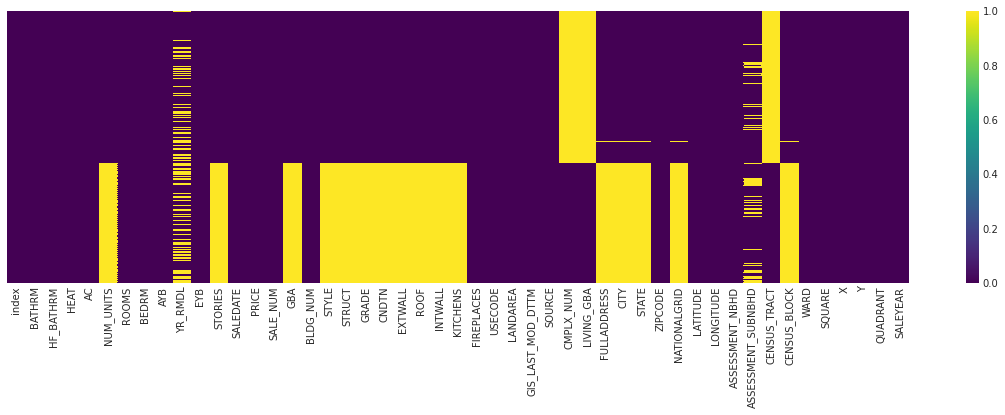

In [14]:
fig, ax = plt.subplots(figsize=(18,5))
sns.heatmap(df3.isnull(), yticklabels=False,cmap='viridis')
plt.show()

Since the missing values seems to have a pattern, we might want to dig deeper into the source (`residential` & `condominium`)

In [15]:
res = df3[df3['SOURCE']=='Residential']
con = df3[df3['SOURCE']=='Condominium']

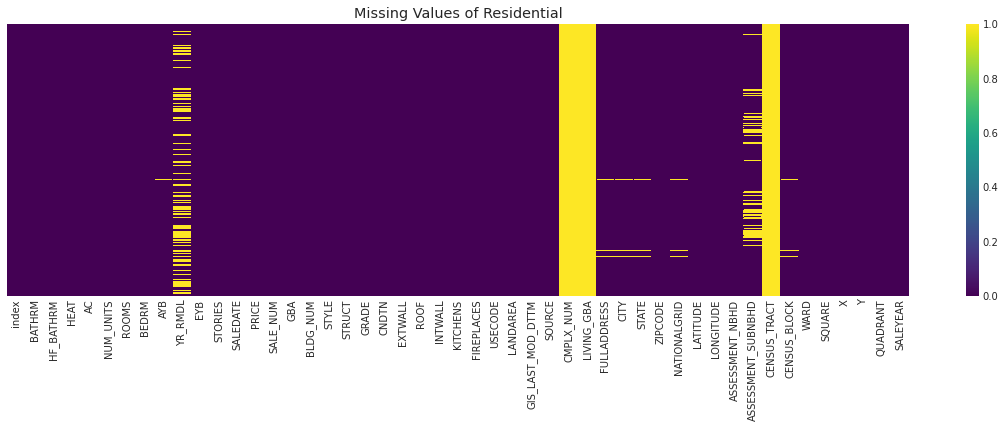

In [16]:
fig, ax = plt.subplots(figsize=(18,5))
sns.heatmap(res.isnull(), yticklabels=False,cmap='viridis').set_title('Missing Values of Residential')
plt.show()

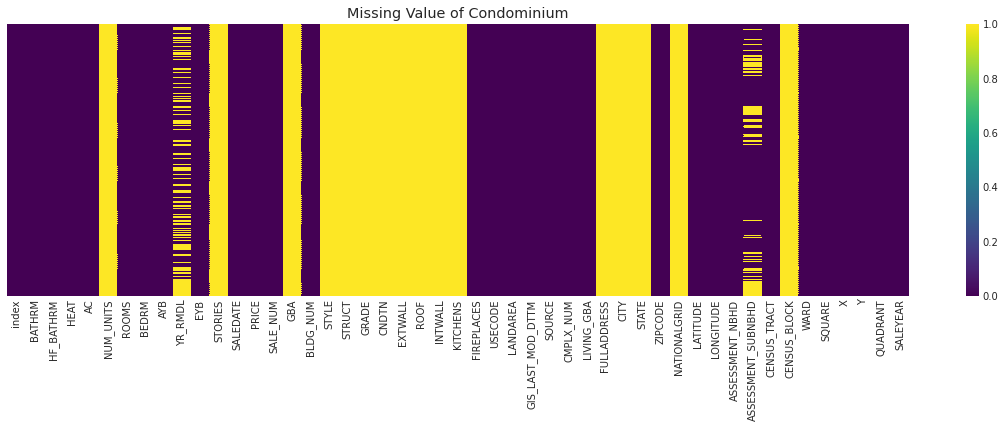

In [17]:
fig, ax = plt.subplots(figsize=(18,5))
sns.heatmap(con.isnull(), yticklabels=False,cmap='viridis').set_title('Missing Value of Condominium')
plt.show()

Clearly, they both have several different features. We assume that the price predictor model of residential and condominium will be different. The condominium data seems to have more missing value than the residential. In this case, we decide to build the price predictor of **`residential`**

In [18]:
def residential(df):
  df = df[df['SOURCE']=='Residential']
  
  return df

In [19]:
df4 = residential(df3)

In [20]:
df4.shape

(15566, 49)

Dropping unused features :
- `CMPLX_NUM`, `LIVING_GBA`, `CENSUS_TRACT` : only available in condominium data
- `ASSESSMENT_SUBNBHD`, `FULLADDRESS`, `NATIONAL GRID`, and `CENSUS_BLOCK` : high cardinality
- `CITY`, `STATE` : single value (Washington, DC)
- `X`, `Y` : same value with `LONGITUDE` and `LATITUDE`
- `SALEDATE` : replaced with `SALEYEAR`

In [21]:
def drop_unused_features(df):
    df = df.drop(['CMPLX_NUM','LIVING_GBA','CENSUS_TRACT','ASSESSMENT_SUBNBHD',
                   'FULLADDRESS','NATIONALGRID','CENSUS_BLOCK','CITY','STATE',
                   'X','Y','SALEDATE'],axis=1)
    return df

In [22]:
df5 = drop_unused_features(df4)

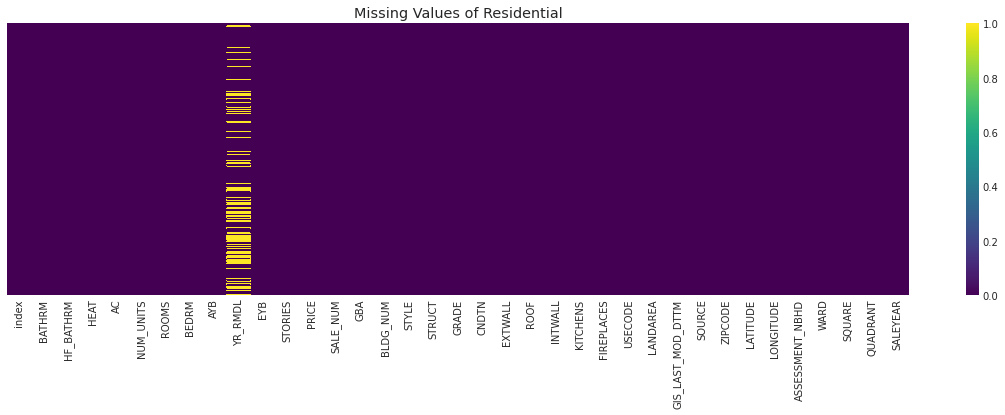

In [23]:
fig, ax = plt.subplots(figsize=(18,5))
sns.heatmap(df5.isnull(), yticklabels=False,cmap='viridis').set_title('Missing Values of Residential')
plt.show()

The `YR_RMDL` features seems too important to drop. Intuitively, whether the properties have been remodeled or not will affect the price. We decide to do feature engineering by converting the `YR_RMDL` into `RMDL`, which is (`1`/`0`). `1` means the property has been remodeled and vice versa.

In [24]:
#feature engineering YR_RMDL
def yr_rmdl(df):
    df['RMDL'] = np.where(df['YR_RMDL'].isna(),0,1)
    df = df.drop('YR_RMDL',axis=1)
    return df

In [25]:
df6 = yr_rmdl(df5)

In [26]:
df6.shape

(15566, 37)

In [27]:
#drop remaining missing values (price)
def drop_all(df):
  df = df.dropna()
  return df

In [28]:
df7 = drop_all(df6)

In [29]:
df7.shape

(15508, 37)

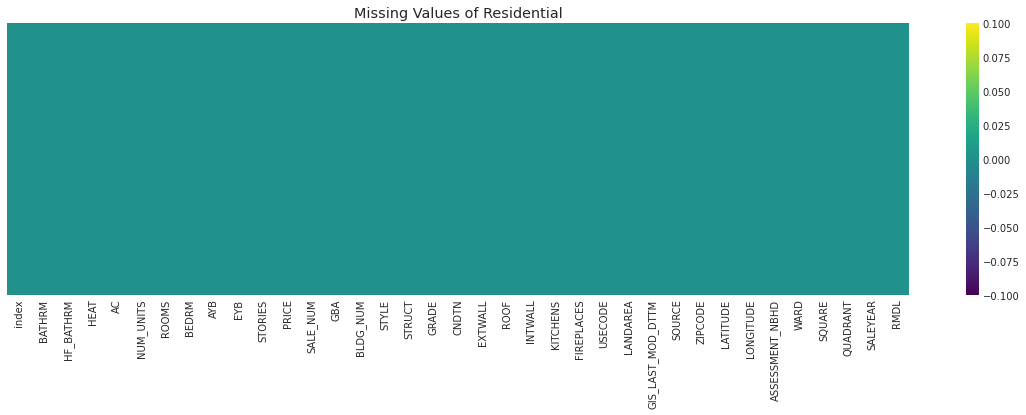

In [30]:
fig, ax = plt.subplots(figsize=(18,5))
sns.heatmap(df7.isnull(), yticklabels=False,cmap='viridis').set_title('Missing Values of Residential')
plt.show()

### 4. UNRELATED COLUMNS

some features do not related to the properties (update version date and source data)

In [31]:
def drop_unrelated_features(df):
    df = df.drop(['GIS_LAST_MOD_DTTM','SOURCE'],axis=1)
    return df

In [32]:
df8 = drop_unrelated_features(df7)

In [33]:
df8.shape

(15508, 35)

### 5. UNUSUAL VALUES

In [34]:
df8['AC'].value_counts() #checking unusual values of AC (0)

Y    13145
N     2358
0        5
Name: AC, dtype: int64

Convert `AC` to `1` and `0` (values of `0` is considered as `N`)

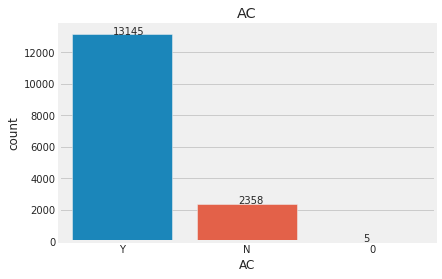

In [35]:
ax = sns.countplot(df7["AC"], 
                   order = df7["AC"].value_counts().index)
plt.title('AC')

for p, label in zip(ax.patches, df7["AC"].value_counts().values):
    ax.annotate(label, (p.get_x()+0.33, p.get_height()+0.5))

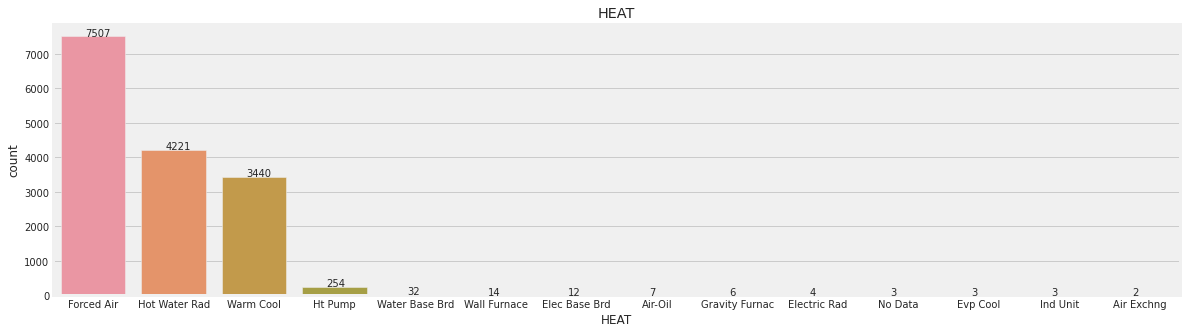

In [36]:
plt.figure(figsize=(18,5))
ax = sns.countplot(df7["HEAT"], 
                   order = df7["HEAT"].value_counts().index)
plt.title('HEAT')

for p, label in zip(ax.patches, df7["HEAT"].value_counts().values):
    ax.annotate(label, (p.get_x()+0.3, p.get_height()+0.5))

In [37]:
df8['HEAT'].value_counts() #checking unusual values of HEAT (No Data)

Forced Air        7507
Hot Water Rad     4221
Warm Cool         3440
Ht Pump            254
Water Base Brd      32
Wall Furnace        14
Elec Base Brd       12
Air-Oil              7
Gravity Furnac       6
Electric Rad         4
No Data              3
Evp Cool             3
Ind Unit             3
Air Exchng           2
Name: HEAT, dtype: int64

Since `No Data` of `HEAT` is considered small, we will drop the records containing it.

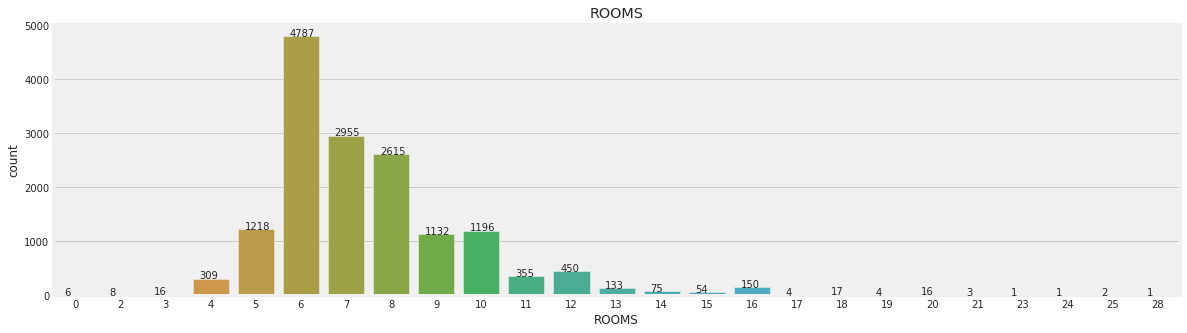

In [38]:
plt.figure(figsize=(18,5))
ax = sns.countplot(df7["ROOMS"], 
                   order = df7["ROOMS"].value_counts().sort_index().index)
plt.title('ROOMS')

for p, label in zip(ax.patches, df7["ROOMS"].value_counts().sort_index().values):
    ax.annotate(label, (p.get_x()+0.15, p.get_height()+0.5))

In [39]:
df8['ROOMS'].value_counts().sort_index() #checking unusual values of ROOMS (0)

0        6
2        8
3       16
4      309
5     1218
6     4787
7     2955
8     2615
9     1132
10    1196
11     355
12     450
13     133
14      75
15      54
16     150
17       4
18      17
19       4
20      16
21       3
23       1
24       1
25       2
28       1
Name: ROOMS, dtype: int64

We will drop properties with `0` room which is highly unlikely 

In [40]:
df8[df8['AYB'] > df8['SALEYEAR']].shape #checking unusual values of interaction between AYB & SALEYEAR

(32, 35)

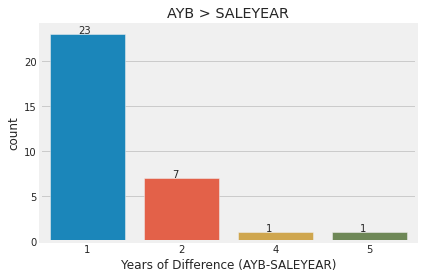

In [41]:
diff_ayb_saleyear = df8[df8['AYB'] > df8['SALEYEAR']]
ax = sns.countplot(diff_ayb_saleyear['AYB'] - diff_ayb_saleyear['SALEYEAR'])
plt.title('AYB > SALEYEAR')
plt.xlabel('Years of Difference (AYB-SALEYEAR)')
for p, label in zip(ax.patches, (diff_ayb_saleyear['AYB'] - diff_ayb_saleyear['SALEYEAR']).value_counts().sort_index().values):
    ax.annotate(label, (p.get_x()+0.3, p.get_height()+0.05))
plt.show() 

We assume there is no sold properties before the properties has been built. Since these values is scarce, we will exclude the records

In [42]:
df8[df8['AYB'] > df8['EYB']].shape #checking unusual values of interaction between AYB & EYB

(2, 35)

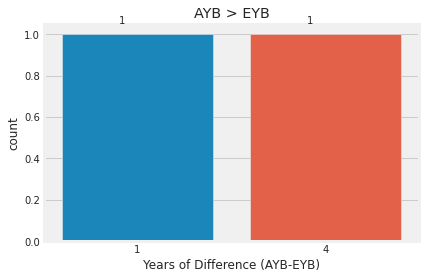

In [45]:
diff_ayb_eyb = df8[df8['AYB'] > df8['EYB']]
ax = sns.countplot(diff_ayb_eyb['AYB'] - diff_ayb_eyb['EYB'])
plt.title('AYB > EYB')
plt.xlabel('Years of Difference (AYB-EYB)')
for p, label in zip(ax.patches, (diff_ayb_eyb['AYB'] - diff_ayb_eyb['EYB']).value_counts().sort_index().values):
    ax.annotate(label, (p.get_x()+0.3, p.get_height()+0.05))
plt.show() 

Based on the Author explanation of the dataset, the `EYB` should be more recent than the `AYB`. We found 2 unusual values, which we will drop

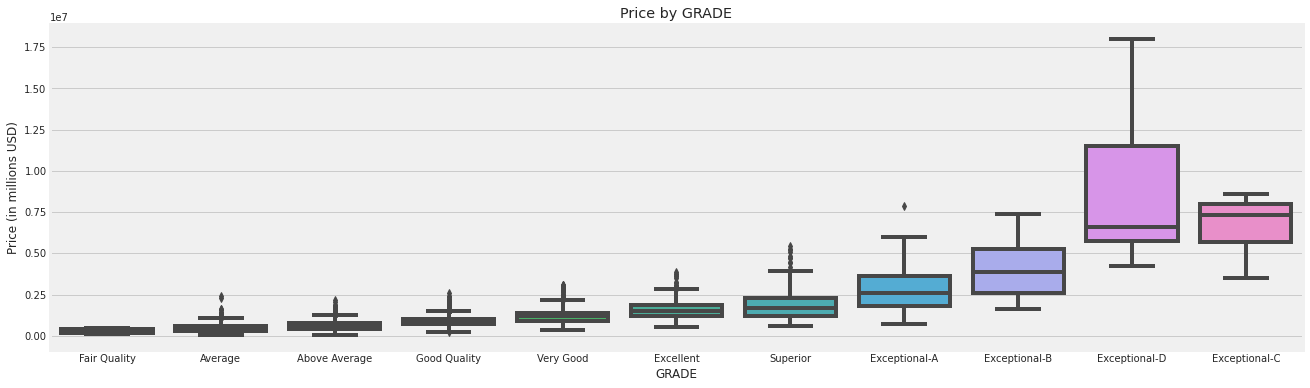

In [46]:
plt.figure(figsize=(20,6))
df_no_na = df8[['GRADE','PRICE']].copy().dropna()
table = df_no_na.groupby(['GRADE'],as_index=False)['PRICE'].median().sort_values(by='PRICE',ascending=True)
sns.boxplot(x='GRADE',y='PRICE',data=df_no_na,order=table['GRADE'].to_list())
plt.ylabel('Price (in millions USD)')
plt.title('Price by GRADE')
plt.show()

In [47]:
df_no_na['GRADE'].value_counts()

Average          4829
Above Average    4693
Good Quality     3407
Very Good        1326
Excellent         539
Superior          473
Exceptional-A     162
Exceptional-B      47
Fair Quality       13
Exceptional-C      12
Exceptional-D       7
Name: GRADE, dtype: int64

In [88]:
# plt.figure(figsize=(20,6))
# order = ['Low Quality', 'Fair Quality', 'Average', 'Above Average','Good Quality','Very Good']
# ax = sns.countplot(df_no_na['GRADE'],order=table['GRADE'].to_list())
# plt.title('Number of Properties by GRADE')
# for p, label in zip(ax.patches, [1,33,11145,10815,7966,3552,1275,1015,319,117,26,22]):
#     ax.annotate(label, (p.get_x()+0.3, p.get_height()+0.7))
# plt.show() 

In [89]:
df8.groupby('GRADE')['PRICE'].median().sort_values() #check price gradient of GRADE

GRADE
Fair Quality      349000.0
Average           454900.0
Above Average     610000.0
Good Quality      855000.0
Very Good        1179500.0
Excellent        1492000.0
Superior         1662000.0
Exceptional-A    2617500.0
Exceptional-B    3895000.0
Exceptional-D    6600000.0
Exceptional-C    7325000.0
Name: PRICE, dtype: float64

In [90]:
df8['GRADE'].value_counts() #check number of records for each GRADE category

Average          4829
Above Average    4693
Good Quality     3407
Very Good        1326
Excellent         539
Superior          473
Exceptional-A     162
Exceptional-B      47
Fair Quality       13
Exceptional-C      12
Exceptional-D       7
Name: GRADE, dtype: int64

Based on the price gradient for each `GRADE`, we can consider the `exceptional` grade as luxurious property. Since the price gap are quite high and the records are rare, we decide to limit our prediction model by excluding those in `exceptional` grade

In [91]:
#drop unusual values
def drop_unusual(df):
  df['AC'] = np.where(df['AC']=='Y',1,0) #convert to 1 0 
  df = df[df['HEAT']!='No Data'] #delete no data
  df = df[df['ROOMS']!=0] #exclude property with 0 rooms
  df = df[df['AYB']<= df['SALEYEAR']] #exclude values where AYB > SALEYEAR
  df = df[df['AYB']<= df['EYB']] #exclude values where AYB > EYB
  df = df[~df['GRADE'].isin(['Exceptional-D','Exceptional-C','Exceptional-B',
                             'Exceptional-A'])] #exclude exceptional GRADE

  return df

In [92]:
df9 = drop_unusual(df8)

In [93]:
df9.shape

(15252, 35)

### 6. SIMILAR VALUES

- `STORIES` has similar values with `STYLE`. We keep `STYLE` since `STORIES` has many outliers due to mistyping.

In [94]:
df9[['STORIES','STYLE']].value_counts()

STORIES  STYLE        
2.00     2 Story          11500
3.00     3 Story           1398
2.50     2.5 Story Fin      727
1.00     1 Story            405
1.50     1.5 Story Fin      206
                          ...  
3.00     1.5 Story Fin        1
2.75     2 Story              1
2.50     Default              1
2.25     Split Level          1
0.00     2 Story              1
Length: 69, dtype: int64

In [95]:
def drop_similar_features(df):
    df = df.drop(['STORIES'], axis=1)
    
    return df

In [96]:
df10 = drop_similar_features(df9)

In [97]:
df10.shape

(15252, 34)

### 7. CORRELATION

CATEGORICAL (CRAMERS V)

In [98]:
from itertools import combinations
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorical-categorical association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

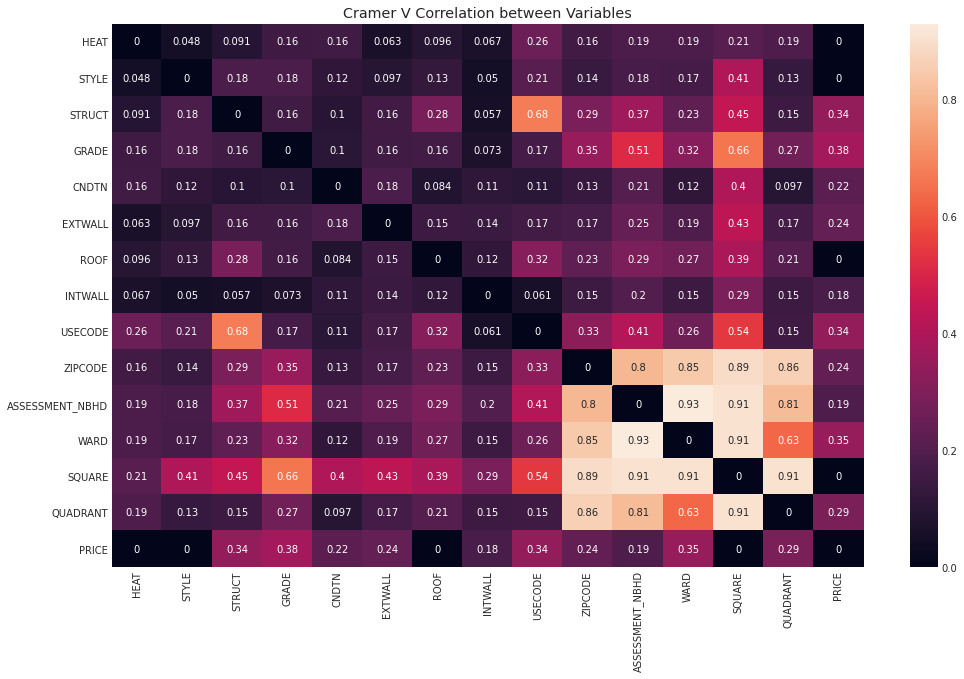

In [99]:
cols = ['HEAT','STYLE','STRUCT', 'GRADE', 'CNDTN', 'EXTWALL','ROOF', 'INTWALL','USECODE','ZIPCODE','ASSESSMENT_NBHD','WARD','SQUARE','QUADRANT','PRICE']
# fitur kategorikal yang diambil yang sekiranya dapat di korelasikan dengan 'Price', kategori geographical yang diambil hanya yang mempunyai distinct data yg kecil
corrM = np.zeros((len(cols),len(cols)))
# there's probably a nice pandas way to do this
for col1, col2 in combinations(cols, 2):
    idx1, idx2 = cols.index(col1), cols.index(col2)
    corrM[idx1, idx2] = cramers_corrected_stat(pd.crosstab(df10[col1], df10[col2]))
    corrM[idx2, idx1] = corrM[idx1, idx2]

corr = pd.DataFrame(corrM, index=cols, columns=cols)
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.heatmap(corr, annot=True, ax=ax); ax.set_title("Cramer V Correlation between Variables");

The location features seems to have interaction with each other. Based on multiple trial on the model, we decide to take only `WARD`, since it is one of the top feature importance according to our model

We also want to drop `LONGLAT` since it is already represented by the `WARD`

In [100]:
df10.columns

Index(['index', 'BATHRM', 'HF_BATHRM', 'HEAT', 'AC', 'NUM_UNITS', 'ROOMS',
       'BEDRM', 'AYB', 'EYB', 'PRICE', 'SALE_NUM', 'GBA', 'BLDG_NUM', 'STYLE',
       'STRUCT', 'GRADE', 'CNDTN', 'EXTWALL', 'ROOF', 'INTWALL', 'KITCHENS',
       'FIREPLACES', 'USECODE', 'LANDAREA', 'ZIPCODE', 'LATITUDE', 'LONGITUDE',
       'ASSESSMENT_NBHD', 'WARD', 'SQUARE', 'QUADRANT', 'SALEYEAR', 'RMDL'],
      dtype='object')

In [101]:
def drop_location_features(df):
    df = df.drop(['ZIPCODE','ASSESSMENT_NBHD','SQUARE','QUADRANT',
                  'LATITUDE','LONGITUDE'], axis=1)
    
    return df

In [102]:
df11 = drop_location_features(df10)

In [103]:
df11.shape

(15252, 28)

NUMERICAL

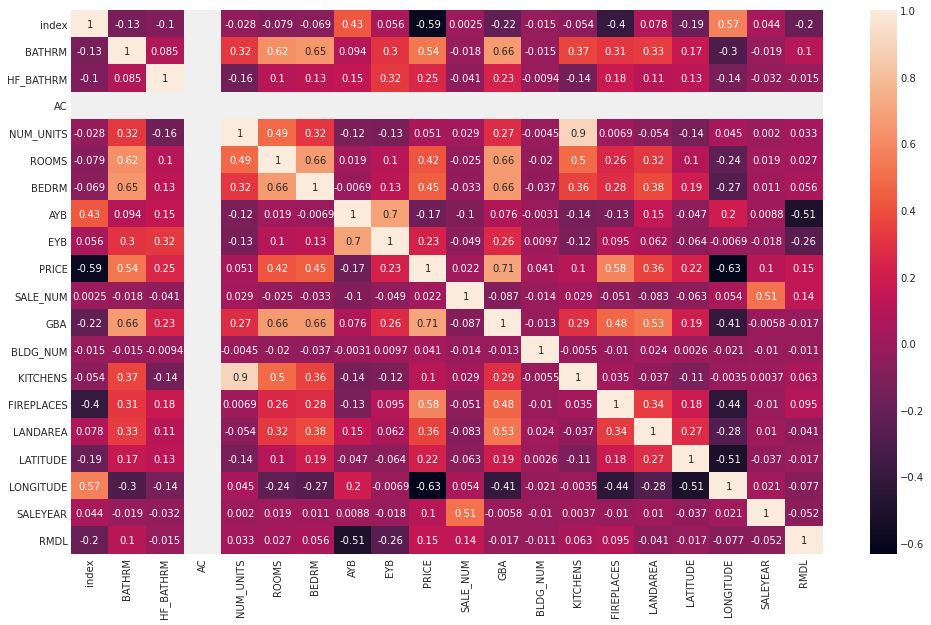

In [104]:
plt.figure(figsize=(15,10))
sns.heatmap(df10.corr(), annot=True)
plt.show()

Some multicollinearity occurs between :
  - `NUM_UNITS` vs `KITCHENS`

Weak correlation :
 - `BLDG_NUM`

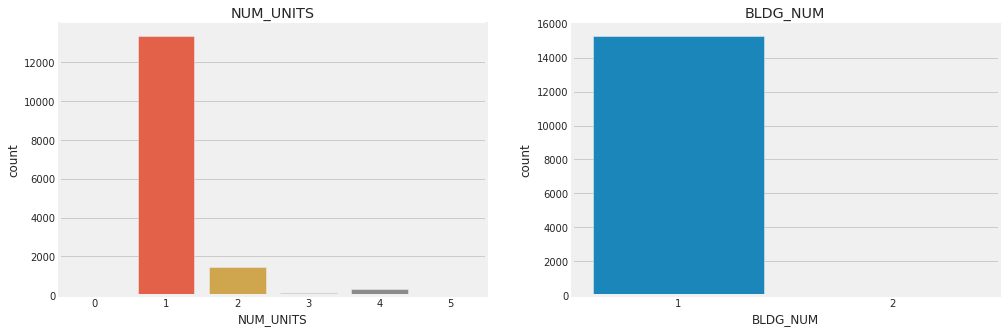

In [105]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
sns.countplot(df11['NUM_UNITS'], ax=ax[0]).set_title('NUM_UNITS')
sns.countplot(df11['BLDG_NUM'], ax=ax[1]).set_title('BLDG_NUM')
plt.show()

Since both of the feature has imbalanced values and is not considered important based on our model trial, we decide to drop both features

In [106]:
def drop_correlation(df):
    df = df.drop(['NUM_UNITS','BLDG_NUM'], axis=1)
    
    return df

In [107]:
df12 = drop_correlation(df11)

In [108]:
df12.columns

Index(['index', 'BATHRM', 'HF_BATHRM', 'HEAT', 'AC', 'ROOMS', 'BEDRM', 'AYB',
       'EYB', 'PRICE', 'SALE_NUM', 'GBA', 'STYLE', 'STRUCT', 'GRADE', 'CNDTN',
       'EXTWALL', 'ROOF', 'INTWALL', 'KITCHENS', 'FIREPLACES', 'USECODE',
       'LANDAREA', 'WARD', 'SALEYEAR', 'RMDL'],
      dtype='object')

In [109]:
df12.shape

(15252, 26)

### 8. FEATURE ENGINEERING

In [110]:
#AYB, EYB change to age, SQFT_ROOMS
def feature_eng(df):
    df['AYB_SALEYEAR_DIFF'] = df['SALEYEAR']-df['AYB']
    df['AYB_SALEYEAR_DIFF'] = df['AYB_SALEYEAR_DIFF'].astype(pd.Int64Dtype())
    
    df['EYB_SALEYEAR_DIFF'] = np.where(df['SALEYEAR']<df['EYB'],0,df['SALEYEAR']-df['EYB'])
    df['EYB_SALEYEAR_DIFF'] = df['EYB_SALEYEAR_DIFF'].astype(pd.Int64Dtype())

    df['SQFT_ROOMS'] = df['GBA']/df['ROOMS']

    df = df.drop(['AYB','EYB'],axis=1)
    return df

In [111]:
#AYB, EYB change to age, SQFT_ROOMS
df13 = feature_eng(df12)

### 9. MODEL EVALUATION

Based on our model evaluation, we drop several features that is insignificant to our model

In [112]:
def drop_model_evaluation(df):
    df = df.drop(['ROOMS','USECODE'],axis=1)

    return df

In [113]:
#drop ROOMS, USECODE
df14 = drop_model_evaluation(df13)

In [114]:
df14.shape

(15252, 25)

### 10. ENCODING

In [115]:
!pip install category_encoders

In [116]:
import category_encoders as ce

In [117]:
#encoding
def encoding_categorical(df):
  ordinal_mapping = [{'col':'CNDTN','mapping':{'Poor':1,'Fair':2,'Average':3,'Good':4,'Very Good':5,'Excellent':6}}]
  ordinal_encoder = ce.OrdinalEncoder(cols ='CNDTN',mapping = ordinal_mapping) 
  df = ordinal_encoder.fit_transform(df)                                                
  return df

In [118]:
df15 = encoding_categorical(df14)                                             

In [119]:
df15.shape

(15252, 25)

### SUMMARY PREPROCESSING

DEV SET

In [120]:
#DEV SET
df1 = casting(df)
df2 = saleyear(df1)
df3 = drop_qualified(df2)
df4 = residential(df3)
df5 = drop_unused_features(df4)
df6 = yr_rmdl(df5)
df7 = drop_all(df6)
df8 = drop_unrelated_features(df7)
df9 = drop_unusual(df8)
df10 = drop_similar_features(df9)
df11 = drop_location_features(df10)
df12 = drop_correlation(df11)
df13 = feature_eng(df12)
df14 = drop_model_evaluation(df13)
df15 = encoding_categorical(df14)

In [121]:
df15.shape

(15252, 25)

In [122]:
df15['ROOF'].value_counts()

Built Up          4716
Metal- Sms        4438
Comp Shingle      4105
Slate             1363
Neopren            311
Shake               93
Shingle             71
Clay Tile           70
Metal- Pre          32
Composition Ro      24
Typical             22
Metal- Cpr           4
Wood- FS             1
Water Proof          1
Concrete             1
Name: ROOF, dtype: int64

In [123]:
df15.columns

Index(['index', 'BATHRM', 'HF_BATHRM', 'HEAT', 'AC', 'BEDRM', 'PRICE',
       'SALE_NUM', 'GBA', 'STYLE', 'STRUCT', 'GRADE', 'CNDTN', 'EXTWALL',
       'ROOF', 'INTWALL', 'KITCHENS', 'FIREPLACES', 'LANDAREA', 'WARD',
       'SALEYEAR', 'RMDL', 'AYB_SALEYEAR_DIFF', 'EYB_SALEYEAR_DIFF',
       'SQFT_ROOMS'],
      dtype='object')

In [124]:
from google.colab import files
df15.to_csv('dev_preproc.csv',index=False)
files.download('dev_preproc.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

TEST SET

In [125]:
df_test = pd.read_csv('https://raw.githubusercontent.com/elvanselvano/purwadhika-final-project/main/dataset/test2.csv') #using test set

In [126]:
#TEST SET
df1_test = casting(df_test)
df2_test = saleyear(df1_test)
df3_test = drop_qualified(df2_test)
df4_test = residential(df3_test)
df5_test = drop_unused_features(df4_test)
df6_test = yr_rmdl(df5_test)
df7_test = drop_all(df6_test)
df8_test = drop_unrelated_features(df7_test)
df9_test = drop_unusual(df8_test)
df10_test = drop_similar_features(df9_test)
df11_test = drop_location_features(df10_test)
df12_test = drop_correlation(df11_test)
df13_test = feature_eng(df12_test)
df14_test = drop_model_evaluation(df13_test)
df15_test = encoding_categorical(df14_test)

In [127]:
from google.colab import files
df15_test.to_csv('test_preproc.csv',index=False)
files.download('test_preproc.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>